A placeholder GPT model architecture class

In [5]:
import torch
import torch.nn as nn

In [8]:
GPT_CONFIG_124M = {
 "vocab_size": 50257,  # Vocabulary size
 "context_length": 1024,  # Context length
 "emb_dim": 768,   # Embedding dimension    
"n_heads": 12,   # Number of attention heads     
"n_layers": 12,   # Number of layers    
"drop_rate": 0.1,   # Dropout rate  
"qkv_bias": False    # Query-Key-Value bias  
}

In [2]:

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]) #
        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) #B
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
 
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
 
class DummyTransformerBlock(nn.Module): #C
    def __init__(self, cfg):
        super().__init__()
 
    def forward(self, x): #D
        return x
 
class DummyLayerNorm(nn.Module): #E
    def __init__(self, normalized_shape, eps=1e-5): #F
        super().__init__()
 
    def forward(self, x):
        return x

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## LLM ARCHITECTURE : LAYER NORMALIZATION

In [4]:
#Explanation with a simple example
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [5]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)

print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## GPT ARCHITECTURE: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

Let's implement the GELU activation function approximation used by GPT-2:

In [3]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later:

In [4]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
GPT_CONFIG_124M = {
 "vocab_size": 50257,  # Vocabulary size
 "context_length": 1024,  # Context length
 "emb_dim": 768,   # Embedding dimension    
"n_heads": 12,   # Number of attention heads     
"n_layers": 12,   # Number of layers    
"drop_rate": 0.1,   # Dropout rate  
"qkv_bias": False    # Query-Key-Value bias  
}

In [7]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [8]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## GPT ARCHITECTURE: SHORTCUT CONNECTIONS

Let us see how we can add shortcut connections to the forward method:

In [9]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


In [14]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[2., 1., -2.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

Next, we implement a function that computes the gradients

In [15]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [16]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00030619598692283034
layers.1.0.weight has gradient mean of 0.0001315188710577786
layers.2.0.weight has gradient mean of 0.0005546467727981508
layers.3.0.weight has gradient mean of 0.0014715546276420355
layers.4.0.weight has gradient mean of 0.0053015160374343395


model with skip connections

In [17]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 2.0485668182373047
layers.1.0.weight has gradient mean of 0.46502214670181274
layers.2.0.weight has gradient mean of 3.061903953552246
layers.3.0.weight has gradient mean of 2.2600228786468506
layers.4.0.weight has gradient mean of 10.654751777648926


### DECODING STRATEGY : TEMPERATURE SCALING

In [1]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

In [2]:
# LETS ASSUME llm generates below logits

In [6]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [7]:
next_token_logits2 = next_token_logits/0.1

next_token_logits3 = next_token_logits/5

In [8]:
probas = torch.softmax(next_token_logits2, dim=0)

print(probas)

tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])


In [9]:
probas = torch.softmax(next_token_logits3, dim=0)

print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [10]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

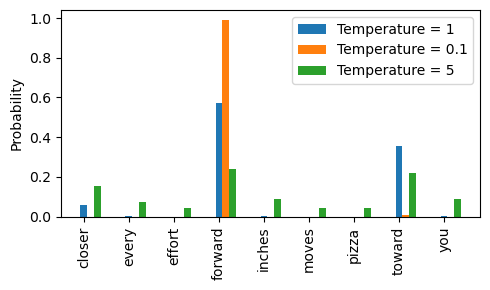

In [12]:
import matplotlib.pyplot as plt
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [13]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [14]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

NameError: name 'model' is not defined